In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Interactive UI
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Cell 1: All libraries imported successfully.")


: 

In [4]:
# --- IMPORTANT ---
# Use the 'r' prefix before your path to avoid errors on Windows.
# Update this path to where you saved the file.
FILE_PATH = r"C:\Users\pawan\OneDrive\Desktop\Coding\dmdwcs\ecommerce_customer_data_custom_ratios.csv"

# Load the dataset
try:
    df = pd.read_csv(FILE_PATH)
    print("File loaded successfully. Here's a preview:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at '{FILE_PATH}'")
    print("Please make sure the file path is correct and run this cell again.")
except Exception as e:
    print(f"An error occurred: {e}")

# Store original dataframe for UI dropdowns later
df_original = df.copy()


File loaded successfully. Here's a preview:


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


--- Initial Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB

Dropped '

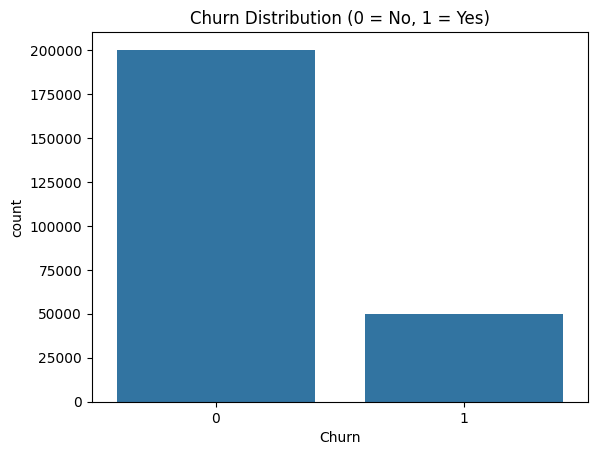


--- Cleaned Data Preview ---


,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn
0,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,0.0,37,Male,0
1,2022-03-05 12:56:35,Home,468,4,2739,PayPal,0.0,37,Male,0
2,2022-05-23 18:18:01,Home,288,2,3196,PayPal,0.0,37,Male,0
3,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,0.0,37,Male,0
4,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,0.0,49,Female,1


In [5]:
if 'df' in locals():
    print("--- Initial Info ---")
    df.info()

    # --- Handle Duplicates ---
    # We see 'Customer Age' and 'Age' are duplicates. Let's drop 'Customer Age'.
    if 'Customer Age' in df.columns:
        df = df.drop('Customer Age', axis=1)
        print("\nDropped 'Customer Age' (duplicate column).")

    # --- Handle Non-Predictive Columns ---
    # Customer ID and Name are unique identifiers and shouldn't be used for prediction.
    if 'Customer ID' in df.columns:
        df = df.drop(['Customer ID', 'Customer Name'], axis=1)
        print("Dropped 'Customer ID' and 'Customer Name'.")

    # --- Handle Missing Values ---
    # 'Returns' seems to have missing values. Let's check.
    print(f"\nMissing values in 'Returns': {df['Returns'].isna().sum()}")
    
    # Let's fill missing 'Returns' with the most common value (the mode), which is likely 0.
    if df['Returns'].isna().sum() > 0:
        mode_return = df['Returns'].mode()[0]
        df['Returns'] = df['Returns'].fillna(mode_return)
        print(f"Filled missing 'Returns' with mode value: {mode_return}")

    # --- Define Target Variable ---
    target = 'Churn'
    print(f"\nTarget variable: '{target}'")
    
    # Check target distribution
    print("\nTarget variable distribution (Churn):")
    print(df[target].value_counts(normalize=True))
    
    sns.countplot(x=target, data=df)
    plt.title("Churn Distribution (0 = No, 1 = Yes)")
    plt.show()

    print("\n--- Cleaned Data Preview ---")
    display(df.head())
else:
    print("Please run Cell 2 to load the data first.")


In [6]:
if 'df' in locals():
    # Convert 'Purchase Date' to datetime objects
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

    # Extract useful features
    df['Purchase_Year'] = df['Purchase Date'].dt.year
    df['Purchase_Month'] = df['Purchase Date'].dt.month
    df['Purchase_DayOfWeek'] = df['Purchase Date'].dt.dayofweek
    df['Purchase_Hour'] = df['Purchase Date'].dt.hour

    # Drop the original 'Purchase Date' column
    df = df.drop('Purchase Date', axis=1)

    print("Feature engineering complete. New time-based features created.")
    display(df.head())
else:
    print("Please run Cell 2 & 3 first.")


Feature engineering complete. New time-based features created.


,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,Purchase_Year,Purchase_Month,Purchase_DayOfWeek,Purchase_Hour
0,Electronics,12,3,740,Credit Card,0.0,37,Male,0,2020,9,1,9
1,Home,468,4,2739,PayPal,0.0,37,Male,0,2022,3,5,12
2,Home,288,2,3196,PayPal,0.0,37,Male,0,2022,5,0,18
3,Clothing,196,1,3509,PayPal,0.0,37,Male,0,2020,11,3,13
4,Home,449,1,3452,Credit Card,0.0,49,Female,1,2020,11,4,17


--- Starting Exploratory Data Analysis (EDA) ---

Plotting: Distribution of Numeric Features


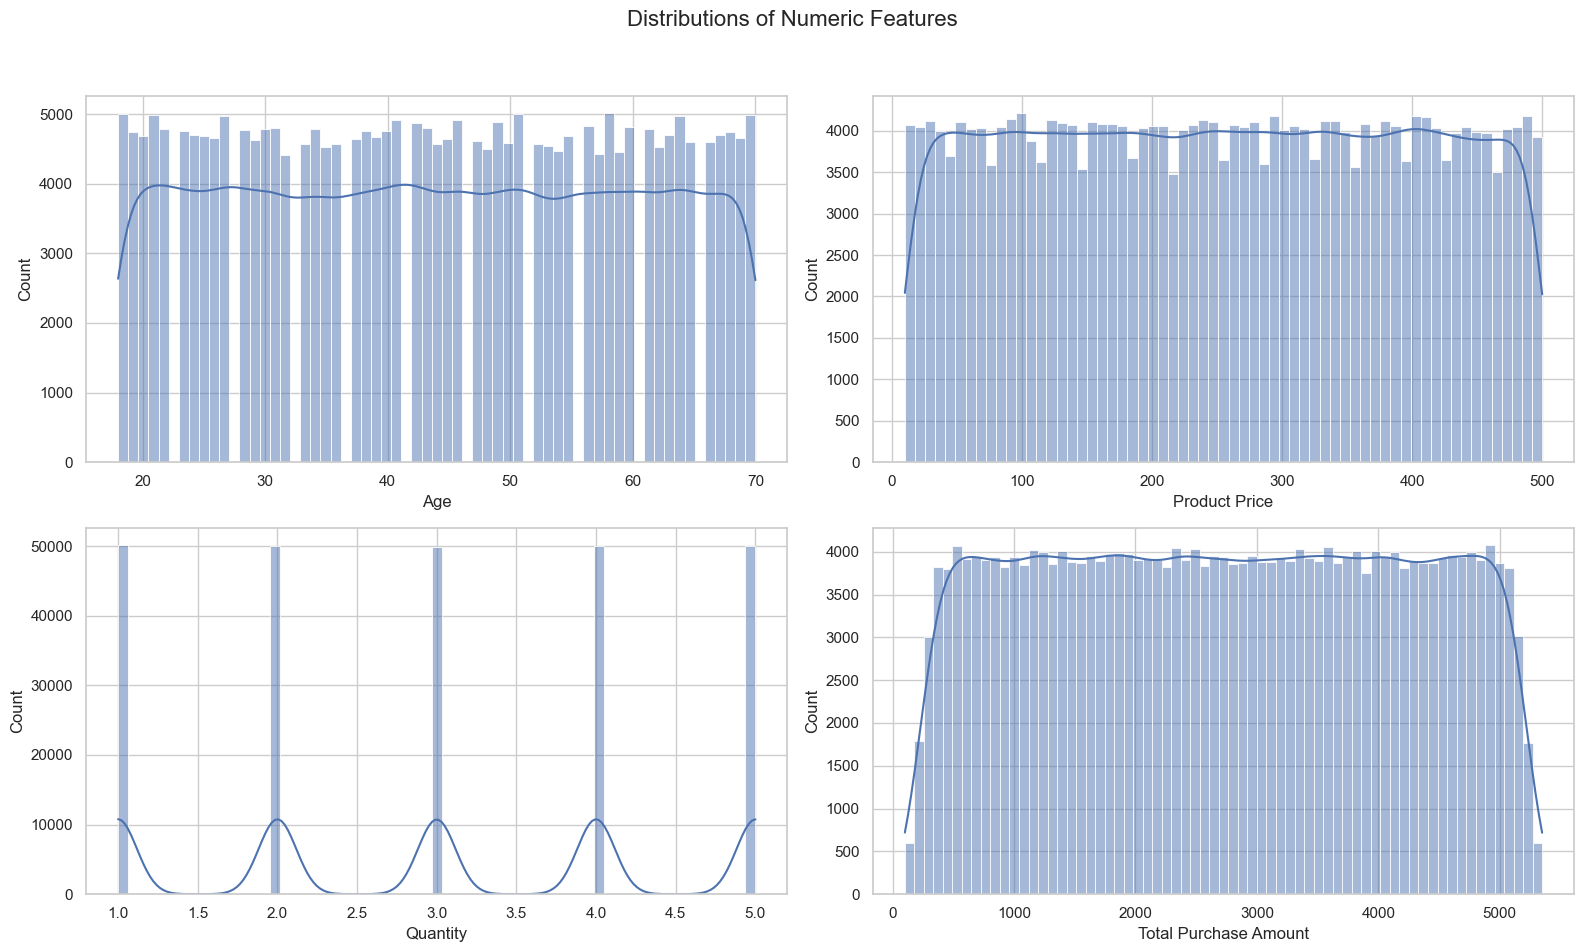


Plotting: Numeric Features vs. Churn


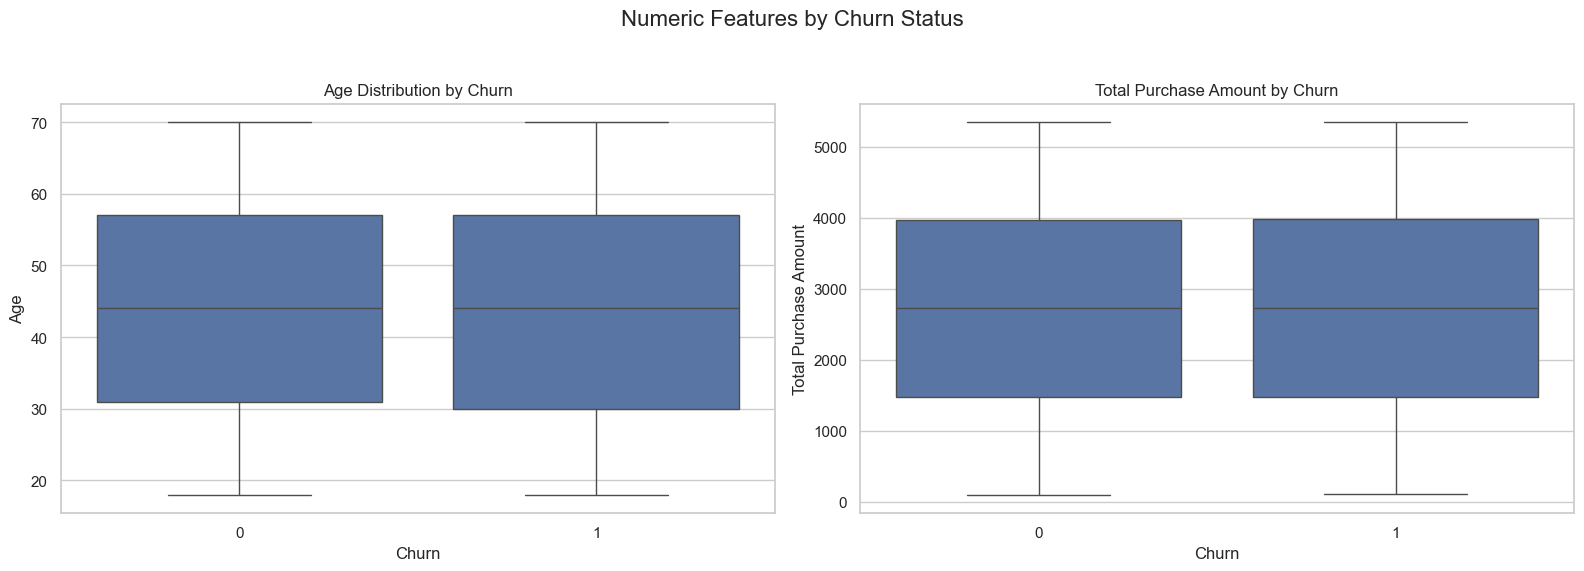


Plotting: Categorical Features vs. Churn (Normalized)


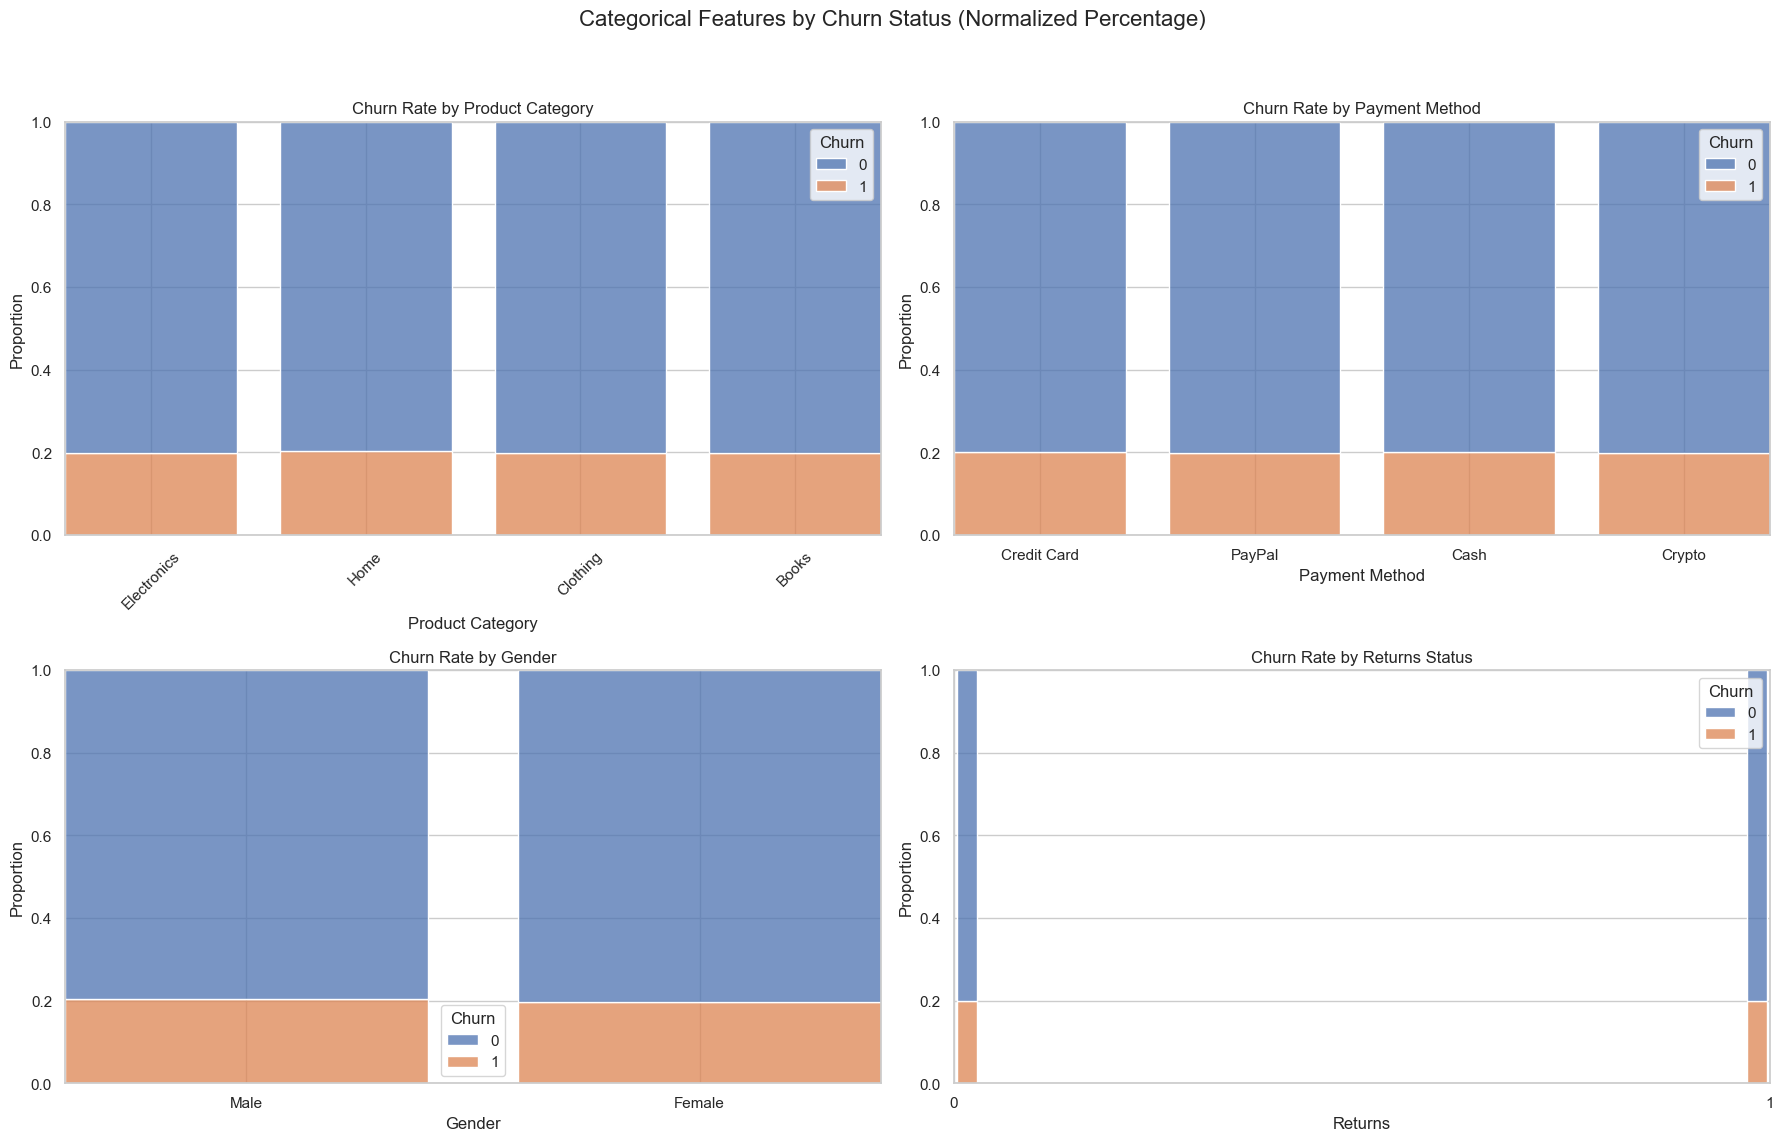


Plotting: Correlation Heatmap of Numeric Features


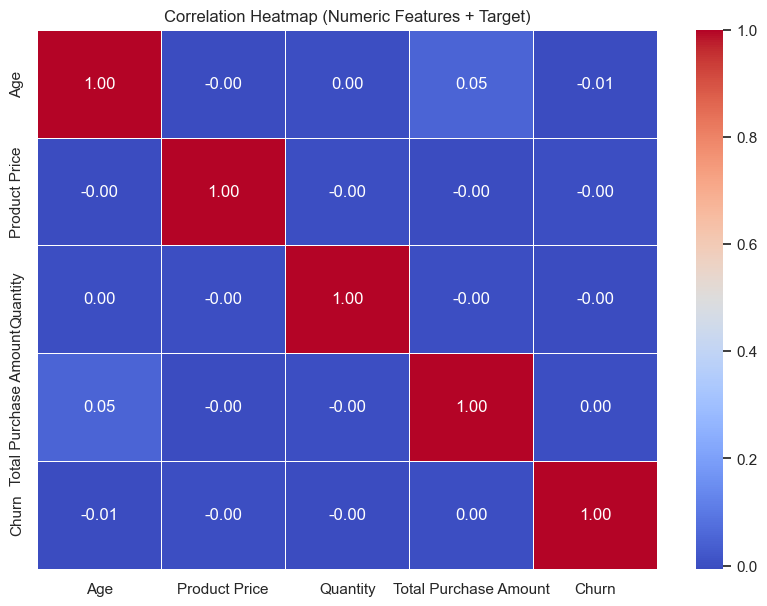


Plotting: Churn Rate by Month


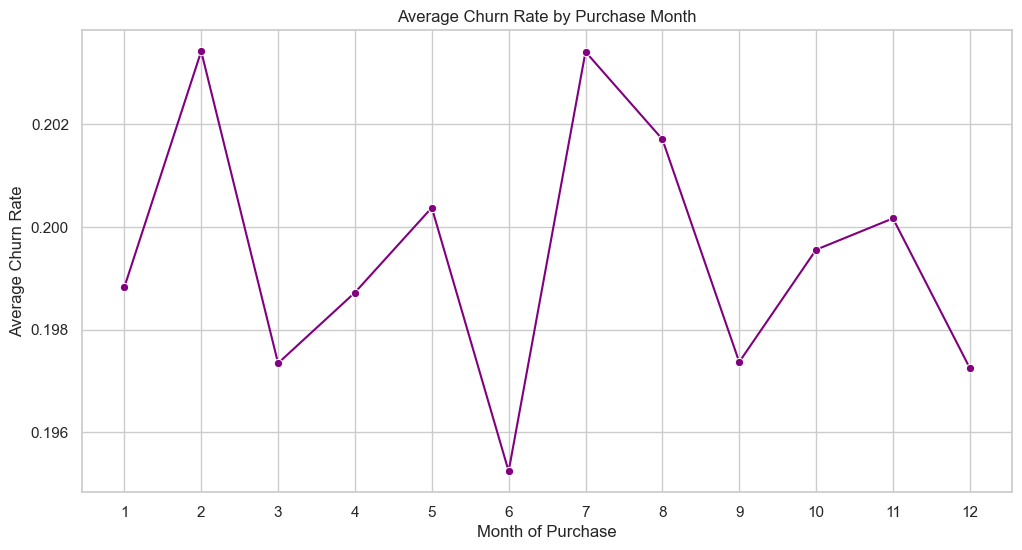

In [7]:
# --- NEW CELL: Exploratory Data Analysis (EDA) ---
# Best to run this after Cell 3 (Cleaning) and Cell 4 (Feature Engineering)

if 'df' in locals():
    print("--- Starting Exploratory Data Analysis (EDA) ---")
    
    # Set the visual style
    sns.set_theme(style="whitegrid")
    
    # Define target and numeric features for plotting
    target = 'Churn'
    numeric_features_for_plot = ['Age', 'Product Price', 'Quantity', 'Total Purchase Amount']
    categorical_features_for_plot = ['Product Category', 'Payment Method', 'Gender', 'Returns']

    
    ## 1. Numeric Feature Distributions
    print("\nPlotting: Distribution of Numeric Features")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Distributions of Numeric Features', fontsize=16)
    
    sns.histplot(df[numeric_features_for_plot[0]], kde=True, ax=axes[0, 0])
    sns.histplot(df[numeric_features_for_plot[1]], kde=True, ax=axes[0, 1])
    sns.histplot(df[numeric_features_for_plot[2]], kde=True, ax=axes[1, 0])
    sns.histplot(df[numeric_features_for_plot[3]], kde=True, ax=axes[1, 1])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    
    ## 2. Numeric Features vs. Target (Churn)
    print("\nPlotting: Numeric Features vs. Churn")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Numeric Features by Churn Status', fontsize=16)
    
    # Boxplot for Age vs. Churn
    sns.boxplot(x=target, y='Age', data=df, ax=axes[0])
    axes[0].set_title('Age Distribution by Churn')
    
    # Boxplot for Total Purchase Amount vs. Churn
    sns.boxplot(x=target, y='Total Purchase Amount', data=df, ax=axes[1])
    axes[1].set_title('Total Purchase Amount by Churn')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    
    ## 3. Categorical Features vs. Target (Churn)
    print("\nPlotting: Categorical Features vs. Churn (Normalized)")
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Categorical Features by Churn Status (Normalized Percentage)', fontsize=16)
    
    # Plotting normalized bar charts to see percentages (churn rate)
    
    # Product Category
    sns.histplot(data=df, x='Product Category', hue=target, multiple='fill', stat='proportion', shrink=0.8, ax=axes[0, 0])
    axes[0, 0].set_title('Churn Rate by Product Category')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].set_ylabel('Proportion')

    # Payment Method
    sns.histplot(data=df, x='Payment Method', hue=target, multiple='fill', stat='proportion', shrink=0.8, ax=axes[0, 1])
    axes[0, 1].set_title('Churn Rate by Payment Method')
    axes[0, 1].set_ylabel('Proportion')

    # Gender
    sns.histplot(data=df, x='Gender', hue=target, multiple='fill', stat='proportion', shrink=0.8, ax=axes[1, 0])
    axes[1, 0].set_title('Churn Rate by Gender')
    axes[1, 0].set_ylabel('Proportion')
    
    # Returns
    sns.histplot(data=df, x='Returns', hue=target, multiple='fill', stat='proportion', shrink=0.8, ax=axes[1, 1])
    axes[1, 1].set_title('Churn Rate by Returns Status')
    axes[1, 1].set_xticks([0, 1]) # Assuming Returns is 0 and 1
    axes[1, 1].set_ylabel('Proportion')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    
    ## 4. Correlation Heatmap
    print("\nPlotting: Correlation Heatmap of Numeric Features")
    plt.figure(figsize=(10, 7))
    # We must include the target variable (Churn) to see its correlation with numeric features
    numeric_df_for_corr = df[numeric_features_for_plot + [target]]
    corr_matrix = numeric_df_for_corr.corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Heatmap (Numeric Features + Target)')
    plt.show()

    
    ## 5. Churn Rate over Time (using your engineered features)
    print("\nPlotting: Churn Rate by Month")
    # Calculate the average churn rate for each month
    monthly_churn = df.groupby('Purchase_Month')[target].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_churn, x='Purchase_Month', y=target, marker='o', color='purple')
    plt.title('Average Churn Rate by Purchase Month')
    plt.ylabel('Average Churn Rate')
    plt.xlabel('Month of Purchase')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.show()

else:
    print("Please run the data loading (Cell 2), cleaning (Cell 3), and feature engineering (Cell 4) first.")

In [8]:
if 'df' in locals():
    # 1. Define features (X) and target (y)
    X = df.drop(target, axis=1)
    y = df[target]

    # 2. Identify numerical and categorical columns
    # We explicitly list them to be safe.
    # Note: 'Returns' is categorical (0 or 1), as are the new date features.
    
    numeric_features = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Age']
    
    categorical_features = ['Product Category', 'Payment Method', 'Gender', 'Returns',
                            'Purchase_Year', 'Purchase_Month', 'Purchase_DayOfWeek', 'Purchase_Hour']

    # 3. Create preprocessing pipelines
    
    # For numerical data: fill NaNs with the median and scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # For categorical data: fill NaNs with the most frequent value and one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # 4. Combine pipelines with ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # In case we missed any columns
    )

    print("Preprocessing pipeline created successfully.")
    print(f"Numeric features: {numeric_features}")
    print(f"Categorical features: {categorical_features}")

    # You can uncomment the line below to 'fit' the preprocessor
    # and see what the transformed data looks like
    # display(pd.DataFrame(preprocessor.fit_transform(X).toarray()))
    
else:
    print("Please run previous cells first.")


Preprocessing pipeline created successfully.
Numeric features: ['Product Price', 'Quantity', 'Total Purchase Amount', 'Age']
Categorical features: ['Product Category', 'Payment Method', 'Gender', 'Returns', 'Purchase_Year', 'Purchase_Month', 'Purchase_DayOfWeek', 'Purchase_Hour']


In [9]:
if 'X' in locals():
    # 1. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

    # 2. Create the full model pipeline
    # This pipeline will first preprocess the data, then feed it to the model
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # 3. Train the model
    print("\nTraining the model...")
    pipeline.fit(X_train, y_train)
    print("Model training complete!")

else:
    print("Please run Cell 5 to define X, y, and the preprocessor.")

Data split: 200000 training samples, 50000 testing samples.

Training the model...
Model training complete!


--- Model Accuracy ---
Accuracy: 0.8005 (or 80.05%)

--- Classification Report ---
               precision    recall  f1-score   support

Not Churn (0)       0.80      1.00      0.89     40025
    Churn (1)       0.00      0.00      0.00      9975

     accuracy                           0.80     50000
    macro avg       0.40      0.50      0.44     50000
 weighted avg       0.64      0.80      0.71     50000


--- Confusion Matrix ---


c:\Users\pawan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pawan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pawan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

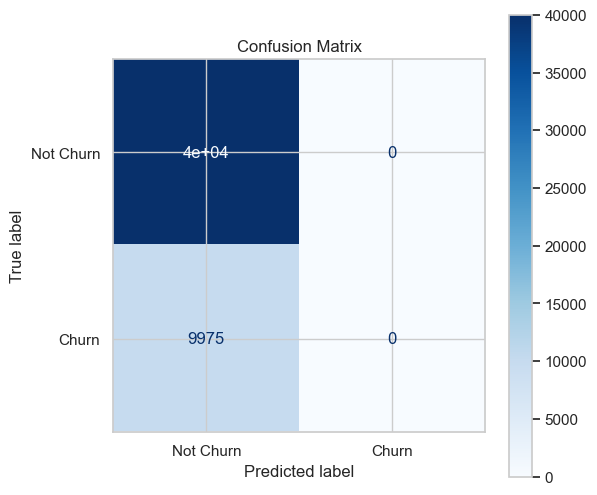

In [10]:
if 'pipeline' in locals():
    # 1. Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Get probabilities for class 1

    # 2. Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"--- Model Accuracy ---")
    print(f"Accuracy: {accuracy:.4f} (or {accuracy*100:.2f}%)")

    # 3. Show Classification Report (Precision, Recall, F1-Score)
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Not Churn (0)', 'Churn (1)']))

    # 4. Display Confusion Matrix
    print("\n--- Confusion Matrix ---")
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test,
                                          display_labels=['Not Churn', 'Churn'],
                                          cmap='Blues',
                                          ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

else:
    print("Please run Cell 6 to train the pipeline first.")

In [11]:
if 'pipeline' in locals() and 'df_original' in locals():
    print("Creating interactive prediction UI...")

    # --- Get unique values for dropdowns from the *original* data ---
    cat_options = df_original['Product Category'].unique()
    pay_options = df_original['Payment Method'].unique()
    gen_options = df_original['Gender'].unique()
    ret_options = sorted(df_original['Returns'].dropna().unique())
    year_options = sorted(pd.to_datetime(df_original['Purchase Date']).dt.year.unique())

    # --- Create Widgets ---
    # Categorical
    w_cat = widgets.Dropdown(options=cat_options, description='Category:')
    w_pay = widgets.Dropdown(options=pay_options, description='Payment:')
    w_gen = widgets.Dropdown(options=gen_options, description='Gender:')
    w_ret = widgets.Dropdown(options=ret_options, description='Returns:')
    w_year = widgets.Dropdown(options=year_options, description='Year:')
    w_month = widgets.IntSlider(min=1, max=12, value=1, description='Month:')
    w_day = widgets.IntSlider(min=0, max=6, value=0, description='Day of Week (0=Mon):')
    w_hour = widgets.IntSlider(min=0, max=23, value=12, description='Hour:')
    
    # Numerical
    w_price = widgets.FloatText(value=100.0, description='Price:')
    w_quant = widgets.IntText(value=1, description='Quantity:')
    w_total = widgets.FloatText(value=100.0, description='Total Pur.:')
    w_age = widgets.IntSlider(min=18, max=80, value=30, description='Age:')

    # Button and Output
    predict_button = widgets.Button(description='Predict Churn', button_style='success')
    output_area = widgets.Output()

    # --- Define Click Function ---
    def on_predict_button_clicked(b):
        with output_area:
            clear_output(wait=True) # Clear previous prediction
            
            # 1. Collect data from widgets
            input_data = {
                'Product Price': [w_price.value],
                'Quantity': [w_quant.value],
                'Total Purchase Amount': [w_total.value],
                'Age': [w_age.value],
                'Product Category': [w_cat.value],
                'Payment Method': [w_pay.value],
                'Gender': [w_gen.value],
                'Returns': [w_ret.value],
                'Purchase_Year': [w_year.value],
                'Purchase_Month': [w_month.value],
                'Purchase_DayOfWeek': [w_day.value],
                'Purchase_Hour': [w_hour.value]
            }

            # 2. Create DataFrame in the *exact* order the model expects
            # This order comes from the 'X' variable in Cell 5
            input_df = pd.DataFrame(input_data)
            input_df = input_df[X.columns] # Ensure column order is correct
            
            # 3. Make prediction
            prediction = pipeline.predict(input_df)[0]
            probability = pipeline.predict_proba(input_df)[0]

            # 4. Display result
            churn_prob = probability[1] * 100
            if prediction == 1:
                print(f"Prediction: WILL CHURN (Result: {prediction})")
                print(f"Confidence: {churn_prob:.2f}%")
            else:
                print(f"Prediction: WILL NOT CHURN (Result: {prediction})")
                print(f"Confidence: {(1-probability[1])*100:.2f}%")

    # --- Link button to function ---
    predict_button.on_click(on_predict_button_clicked)

    # --- Display UI ---
    # Organize into boxes for a cleaner layout
    col1 = widgets.VBox([w_cat, w_pay, w_gen, w_ret])
    col2 = widgets.VBox([w_price, w_quant, w_total, w_age])
    col3 = widgets.VBox([w_year, w_month, w_day, w_hour])
    
    ui_inputs = widgets.HBox([col1, col2, col3])
    ui = widgets.VBox([ui_inputs, predict_button, output_area])

    print("UI is ready. Enter customer data and click 'Predict Churn'.")
    display(ui)

else:
    print("Please run all previous cells to train the model and load data.")


Creating interactive prediction UI...
UI is ready. Enter customer data and click 'Predict Churn'.


In [12]:
if 'pipeline' in locals() and 'X_test' in locals() and 'y_test' in locals():
    print("--- Running Simple Test Predictions ---")
    
    # Let's grab the first 5 samples from the test set
    test_samples = X_test.head(5)
    actual_labels = y_test.head(5)
    
    print("Making predictions on 5 samples from the test data...")
    
    # Make predictions
    predictions = pipeline.predict(test_samples)
    probabilities = pipeline.predict_proba(test_samples)
    
    # Display the results
    results_df = pd.DataFrame({
        'Actual Churn': actual_labels,
        'Predicted Churn': predictions
    })
    
    # Add probabilities for the 'Churn (1)' class
    results_df['Churn Probability (%)'] = probabilities[:, 1] * 100
    results_df['Churn Probability (%)'] = results_df['Churn Probability (%)'].map('{:,.2f}%'.format)

    print("\n--- Prediction Results ---")
    display(results_df)
    
    print("\n--- Details of Test Data Used ---")
    display(test_samples)

else:
    print("Please run all previous cells (1-7) to train the model and create test data.")



--- Running Simple Test Predictions ---
Making predictions on 5 samples from the test data...

--- Prediction Results ---


,Actual Churn,Predicted Churn,Churn Probability (%)
158231,0,0,20.52%
58129,0,0,20.27%
38975,0,0,21.19%
246863,0,0,19.74%
61471,0,0,19.43%



--- Details of Test Data Used ---


,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Purchase_Year,Purchase_Month,Purchase_DayOfWeek,Purchase_Hour
158231,Clothing,105,4,597,Credit Card,0.0,23,Male,2022,4,6,7
58129,Books,372,3,5016,Crypto,1.0,27,Male,2021,12,0,13
38975,Clothing,41,3,4118,PayPal,0.0,39,Male,2022,11,2,16
246863,Home,294,4,4980,Credit Card,1.0,66,Male,2022,4,1,15
61471,Electronics,218,2,798,Credit Card,1.0,27,Female,2023,3,3,22


In [1]:
# --- [New Cell] Exploratory Data Analysis (EDA) Plots ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# We use 'df' which is the original, un-aggregated dataframe
# First, create the 'PurchaseMode' column as a proxy for 'Online' vs. 'Offline'
def map_purchase_mode(payment_method):
    if payment_method == 'Cash':
        return 'Offline'
    elif payment_method in ['Credit Card', 'PayPal']:
        return 'Online'
    else:
        return 'Other' # This will capture 'Crypto'

# Ensure the 'df' variable is your loaded DataFrame
df_plot = df.copy()
df_plot['PurchaseMode'] = df_plot['Payment Method'].apply(map_purchase_mode)
df_plot['Returns'] = df_plot['Returns'].fillna(0) # Clean returns as in your notebook

print(f"Purchase modes identified: {df_plot['PurchaseMode'].unique()}")

# --- Plot 1: Overall Purchase Mode Distribution (Pie Chart) ---
plt.figure(figsize=(8, 8))
mode_counts = df_plot['PurchaseMode'].value_counts()
plt.pie(mode_counts, labels=mode_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Pastel1'))
plt.title('Distribution of Online vs. Offline Purchases', fontsize=16, fontweight='bold')
plt.savefig('plot1_purchase_mode_distribution.png')
plt.show()

# --- Plot 2: Purchase Mode by Product Category (Bar Chart) ---
plt.figure(figsize=(12, 7))
sns.countplot(data=df_plot, y='Product Category', hue='PurchaseMode', order=df_plot['Product Category'].value_counts().index, palette='muted')
plt.title('Purchases by Product Category and Mode', fontsize=16, fontweight='bold')
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.legend(title='Purchase Mode')
plt.tight_layout()
plt.savefig('plot2_purchases_by_category_and_mode.png')
plt.show()

# --- Plot 3: Purchase Amount by Purchase Mode (Box Plot) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='PurchaseMode', y='Total Purchase Amount', palette='Set2')
plt.title('Total Purchase Amount by Purchase Mode', fontsize=16, fontweight='bold')
plt.xlabel('Purchase Mode', fontsize=12)
plt.ylabel('Total Purchase Amount ($)', fontsize=12)
plt.savefig('plot3_amount_by_mode.png')
plt.show()

# --- Plot 4: Churn Rate by Purchase Mode ---
# Calculate churn rate (mean of the 'Churn' column)
churn_rate = df_plot.groupby('PurchaseMode')['Churn'].mean().reset_index()
churn_rate['Churn Rate'] = churn_rate['Churn'] * 100  # Convert to percentage

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_rate, x='PurchaseMode', y='Churn Rate', palette='viridis')
plt.title('Customer Churn Rate by Purchase Mode', fontsize=16, fontweight='bold')
plt.xlabel('Purchase Mode', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontweight='bold')
                
plt.savefig('plot4_churn_by_mode.png')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'